# ISC analysis with levels

Remark: could be the most promising.

`beta_series glm25 subj* nosmooth`

## Main goals

The BOLD signal contains noise. Here, we calculate correlations between subjects to reduce noise and estimate task-relevant signals. Want to find brain regions where the same levels of activity are displayed. Key predictions are that, in the theory encoding region, the ISC should:

1. Be highest for same levels, medium for same games, and lowest for random (shuffled) games
2. Increase over levels of the same game

---

## Outline

0. Load data in
1. Preprocess data
    - Clean up strings
    - Reorder BOLD data based on names
    - 
3. ISC

In [40]:
import h5py
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import glob
import time
from copy import deepcopy
import numpy as np
import pandas as pd 

from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
import nibabel as nib

from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
from brainiak.isc import compute_summary_statistic
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 
import seaborn as sns 
import hdf5storage
import mat73
import pandas as pd
from importlib import reload 

# import own functions
import utils
from utils import decode_variable, get_in_shape_levels
reload(utils)


%autosave 30
%matplotlib inline
sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

Autosaving every 30 seconds


# 0. Load in data


In [41]:
data_dir = '/Users/Daphne/Desktop/beta_series/' # local directory 
filename = 'beta_series_glm25_subj1_nosmooth.mat' # specify filename

os.path.exists(data_dir) 

True

In [42]:
num_subjects = 8

B_data = []
mask_data = []
Vmask_data = []
names_data = []

for i in range(num_subjects):
    idx = i+1
    
    # change filename to subject #
    data_dir = '/Users/Daphne/Desktop/beta_series/'
    filename = 'beta_series_glm25_subjk_nosmooth.mat'
    filename = filename.replace('k', str(idx))
    
    subject = h5py.File(data_dir+filename,'r') 
    #print(list(subject.keys()))
    print(f'Get data for subject {idx}')
    # load and save data for respective subject
    B = subject['B'].value
    mask = subject['mask'].value
    Vmask = subject['Vmask']
    
    # === decode level names ===
    names = decode_variable(data_dir+filename, 'names')
    
    # append to lists
    B_data.append(B)
    mask_data.append(mask)
    Vmask_data.append(Vmask)
    names_data.append(names)

Get data for subject 1
Get data for subject 2
Get data for subject 3
Get data for subject 4
Get data for subject 5
Get data for subject 6
Get data for subject 7
Get data for subject 8


In [43]:
B_data[0].shape # voxels x levels

(179595, 54)

In [44]:
mask_data[0].shape

(79, 95, 79)

In [45]:
names_data[0].shape # 54 levels (18 blocks x 3 levels per block)

(54,)

In [46]:
print(names_data[0][0:10])

['Sn(1) vgfmri3_chase_run_1_block_1_instance_1*bf(1)'
 'Sn(1) vgfmri3_chase_run_1_block_1_instance_2*bf(1)'
 'Sn(1) vgfmri3_chase_run_1_block_1_instance_3*bf(1)'
 'Sn(1) vgfmri3_lemmings_run_1_block_2_instance_1*bf(1)'
 'Sn(1) vgfmri3_lemmings_run_1_block_2_instance_2*bf(1)'
 'Sn(1) vgfmri3_lemmings_run_1_block_2_instance_3*bf(1)'
 'Sn(1) vgfmri3_bait_run_1_block_3_instance_1*bf(1)'
 'Sn(1) vgfmri3_bait_run_1_block_3_instance_2*bf(1)'
 'Sn(1) vgfmri3_bait_run_1_block_3_instance_3*bf(1)'
 'Sn(2) vgfmri3_plaqueAttack_run_2_block_1_instance_1*bf(1)']


# 1. Preprocessing

1. Clean the level name strings

2. Reorder the BOLD data

    - split the list of strings `names` into 3 parts: `game, instance, session`.
    - sort the data first by game, then session, then level (default = quicksort)
    - insert a levels column to the ordered dataframes
    
<font color=red>TODO: check if the reordering is the same among all matrices. Order: game, session (run), instance.</font>


In [47]:
ISC_data = []
ordered_dfs = []
clean_names_arr = [] 

for s in range(num_subjects):
    
    print(f'Preprocess fMRI data for subject {s+1}')
    # get the betas and game order from this
    B_s = B_data[s].T # transpose to get [blocks, voxels]
    names_s = names_data[s]
    
    level_names, dfOrdered, B_ordered = get_in_shape_levels(B_s, names_s)
    
    ISC_data.append(B_ordered)
    ordered_dfs.append(dfOrdered)
    clean_names_arr.append(level_names)
    
ISC_arr = np.array(ISC_data)

Preprocess fMRI data for subject 1
Preprocess fMRI data for subject 2
Preprocess fMRI data for subject 3
Preprocess fMRI data for subject 4
Preprocess fMRI data for subject 5
Preprocess fMRI data for subject 6
Preprocess fMRI data for subject 7
Preprocess fMRI data for subject 8


Check if the ordering went well

In [48]:
ordered_dfs[0].head(10)

,game,session,instance,level,0,1,2,3,4,5,...,179585,179586,179587,179588,179589,179590,179591,179592,179593,179594
6,bait_run_1_block_3,Sn(1),1,1,19.199156,28.537733,10.239181,17.694250,23.295395,16.627344,...,25.128340,5.425324,13.004602,15.042298,-6.364879,-11.392531,1.708822,-99.975784,-15.312428,-8.962795
7,bait_run_1_block_3,Sn(1),2,2,13.383988,22.621550,8.590137,14.528902,18.865812,16.166079,...,34.772739,21.535751,13.527284,31.084429,-0.163805,-8.713621,3.358230,-60.397491,-8.576245,-35.068432
8,bait_run_1_block_3,Sn(1),3,3,2.549607,1.636920,-2.231498,0.967521,8.795676,4.721345,...,24.144020,19.712748,13.561014,30.131161,0.246335,-6.191958,-1.884874,-47.639793,1.113926,-46.707954
30,bait_run_4_block_2,Sn(4),1,4,-16.978617,-16.729130,-29.648905,-23.597483,-15.209856,-14.191240,...,14.080072,4.484744,-0.346018,4.350897,3.916380,16.256346,2.148632,112.382652,-12.371770,-4.320034
31,bait_run_4_block_2,Sn(4),2,5,-14.978524,-18.707935,-30.641397,-20.043365,-9.567141,-12.577331,...,26.819010,16.529627,2.767518,17.505005,8.527705,18.312983,7.945537,202.694626,-3.178994,8.647114
32,bait_run_4_block_2,Sn(4),3,6,-8.976464,-11.410330,-24.664267,-15.185419,3.238928,-12.107245,...,9.920098,11.000279,0.914053,5.058023,2.494267,9.473378,0.785467,76.846008,-0.824027,-2.499896
51,bait_run_6_block_3,Sn(6),1,7,-2.395476,1.513109,-4.143730,-11.670125,-1.328365,6.780948,...,10.011159,7.723665,9.655613,7.811440,4.867677,0.321225,1.457879,-69.588699,-20.283146,37.739288
52,bait_run_6_block_3,Sn(6),2,8,-1.689099,-8.259522,-3.950547,-6.117507,2.691304,8.296554,...,4.914059,8.628613,2.384176,1.688269,5.207636,4.415186,1.136446,-37.430626,-22.867521,51.771412
53,bait_run_6_block_3,Sn(6),3,9,11.910543,2.318130,3.446300,-0.911807,17.847729,20.634420,...,5.933125,3.864615,-2.346202,-0.982619,7.742257,8.865562,2.986924,5.154943,-12.691116,50.910248
0,chase_run_1_block_1,Sn(1),1,1,15.721817,25.085579,2.968380,-2.639888,6.473232,1.678652,...,19.972883,8.372100,6.761074,18.581575,-8.105068,-8.357821,2.474474,1.900306,-10.015869,-10.022240


In [49]:
ordered_dfs[1].head(10)

,game,session,instance,level,0,1,2,3,4,5,...,179585,179586,179587,179588,179589,179590,179591,179592,179593,179594
12,bait_run_2_block_2,Sn(2),1,1,12.622788,10.560690,-19.487274,-29.014172,14.883762,35.584770,...,-1.138859,2.909694,3.343966,5.025532,0.998662,5.899458,-0.813421,4.542686,1.111323,16.174570
13,bait_run_2_block_2,Sn(2),2,2,22.645777,25.441219,6.836761,-9.466741,27.235197,47.326832,...,-0.077553,2.249466,-1.689298,1.770904,-1.357569,6.520052,0.577175,1.149024,0.460771,15.243050
14,bait_run_2_block_2,Sn(2),3,3,20.131908,22.645388,-0.100762,-2.583528,5.873880,32.628700,...,-2.473970,5.439982,8.312366,6.913280,10.590742,3.020605,6.346278,12.930584,0.126875,17.043709
27,bait_run_4_block_1,Sn(4),1,4,-4.028922,-0.960551,-11.744263,-17.141655,-8.486115,2.035394,...,-3.455634,-1.618602,-9.932774,-3.297248,-2.802044,-3.405606,-8.564713,-4.515105,-5.239591,-2.875939
28,bait_run_4_block_1,Sn(4),2,5,-5.358232,-11.941525,-18.518099,-28.022066,-20.103676,-3.807915,...,-3.570256,-7.496143,-3.528990,-2.389893,-5.169400,2.011414,-2.370140,-14.248380,-5.678710,0.180691
29,bait_run_4_block_1,Sn(4),3,6,-3.289346,-9.529417,-10.966561,-14.048309,-13.675561,6.671819,...,-3.725421,-5.532433,-4.116204,-1.472339,-5.407729,0.905134,-2.477087,-9.207439,-7.029817,-0.357202
45,bait_run_6_block_1,Sn(6),1,7,17.770460,28.780867,16.646635,17.684668,17.830238,20.876541,...,3.428375,-1.501030,0.716047,0.040213,-7.763398,-2.171905,-0.400742,4.099455,-1.167492,-7.862901
46,bait_run_6_block_1,Sn(6),2,8,21.946180,39.912300,31.525814,34.486820,27.241163,30.244564,...,11.021452,0.142435,4.736644,-2.778926,-2.871173,-0.386099,1.457265,8.526863,-4.220927,-2.965729
47,bait_run_6_block_1,Sn(6),3,9,11.001765,28.822695,25.183443,23.955667,19.383125,22.343418,...,9.837715,2.404170,0.959153,-2.527512,-4.743040,-2.730107,-1.865690,10.502961,-8.231742,-7.207443
3,chase_run_1_block_2,Sn(1),1,1,0.559279,17.911493,8.225637,-1.511254,-4.160404,5.953154,...,4.383714,-0.390894,-5.802358,-1.932495,-3.153919,3.083772,-16.073875,-6.837111,-6.147096,4.730759


In [50]:
ordered_dfs[4].head(10)

,game,session,instance,level,0,1,2,3,4,5,...,179585,179586,179587,179588,179589,179590,179591,179592,179593,179594
9,bait_run_2_block_1,Sn(2),1,1,-1.297264,0.776195,-0.979126,0.394211,5.485322,-2.308117,...,2.074114,11.921281,17.436504,1.238942,-11.774035,-15.175616,-10.654403,-4.358250,0.163413,-2.010511
10,bait_run_2_block_1,Sn(2),2,2,-0.155788,2.411752,-6.357719,-2.868175,7.175553,-4.923314,...,-4.893945,-0.054070,-0.000255,1.001908,-8.264713,-4.658238,4.493925,-8.757041,8.348822,-1.239421
11,bait_run_2_block_1,Sn(2),3,3,9.446040,6.626942,-4.133158,3.680997,8.458634,-8.073539,...,-3.711507,1.423281,10.506694,-4.031930,5.801072,-13.035699,4.693395,-3.608596,-13.188322,0.591490
21,bait_run_3_block_2,Sn(3),1,4,10.153196,0.756708,-11.356050,3.836738,6.469186,6.377638,...,-26.704519,0.817805,4.713699,7.786730,-33.215809,-21.887068,-23.393812,4.506283,-6.979872,-8.811018
22,bait_run_3_block_2,Sn(3),2,5,11.875322,-2.164119,-7.384070,5.003842,6.662201,-3.259584,...,14.938351,11.078907,-4.000596,12.283837,-25.664736,-22.935234,6.649169,-19.374006,-5.245306,-8.589372
23,bait_run_3_block_2,Sn(3),3,6,10.355932,-4.536863,-9.017297,1.570958,4.225239,-6.618831,...,12.034833,18.937906,-11.686545,21.814283,-22.407936,-11.378942,8.367990,-11.981944,-10.016057,-9.205645
48,bait_run_6_block_2,Sn(6),1,7,0.071559,-5.326776,-9.222593,-8.373965,-0.915545,-8.185764,...,-11.897472,18.866547,30.477980,-16.604477,5.481881,-26.646626,-19.238327,19.058506,-0.726427,-2.457946
49,bait_run_6_block_2,Sn(6),2,8,-0.194086,-5.231183,-6.957048,-9.398629,-3.290849,-2.284647,...,-15.378532,17.094791,28.825178,-15.714142,22.072313,-26.560596,-23.217505,31.748421,-6.830576,-0.746495
50,bait_run_6_block_2,Sn(6),3,9,2.155529,-2.089905,-2.402771,-7.324143,1.256305,-4.685737,...,-11.800708,27.244520,38.539921,-15.547113,-5.242094,-33.377426,-35.127308,38.898582,6.916323,-4.242664
15,chase_run_2_block_3,Sn(2),1,1,11.618948,8.798475,5.570344,4.742844,12.450085,-1.713956,...,3.932240,1.727601,3.055186,4.760774,-5.331942,-3.422200,11.753897,-14.827938,-11.245288,-5.293252


In [51]:
ISC_arr.shape

(8, 54, 179596)

In [52]:
ISC_arr = np.swapaxes(ISC_arr, 0, 1) # need to get [TRs, voxels, subjects]
ISC_arr = np.swapaxes(ISC_arr, 1, 2)

ISC_arr.shape # [levels, voxels, subjects]

(54, 179596, 8)

## 2. ISC

We perform an ISC in two different ways. 

## 2.1 Do ISC and obtain a matrix

We can do an ISC either by treating each row (**block**) as a variable, or by treating each column (**voxel**) as a variable.

### Correlating the voxel patterns of the respective blocks

- In the study from (Chen et al., 2016) they divided the BOLD data obtained from watching and recalling a Sherlock movie up in 50 scenes. This resulted in one vector voxel values for each recalled scene. As such, they compute the correlation between every matching pair of recalled scenes (see img top right).
- In our case, this is equivalent to treating the levels, (i.e. **rows**), as a variable and compute the correlation between each respective level voxel pattern.
- <font color=red>TODO: interpret results </font> 

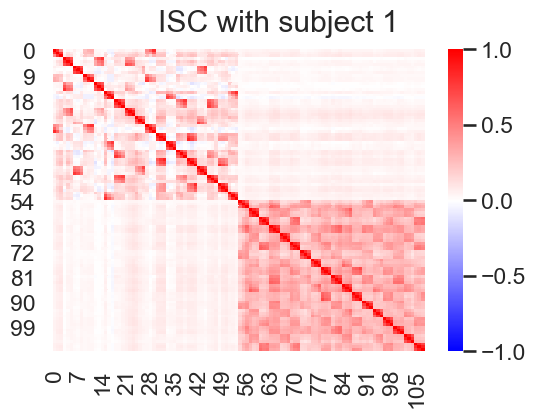

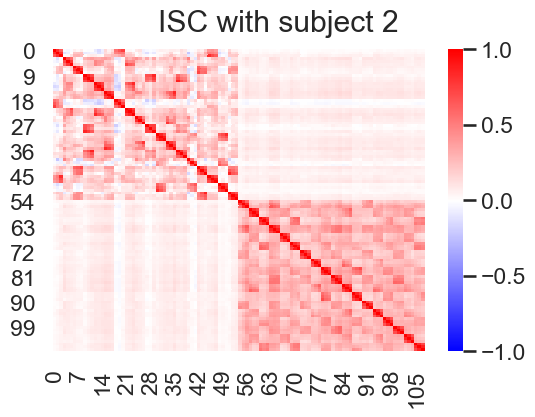

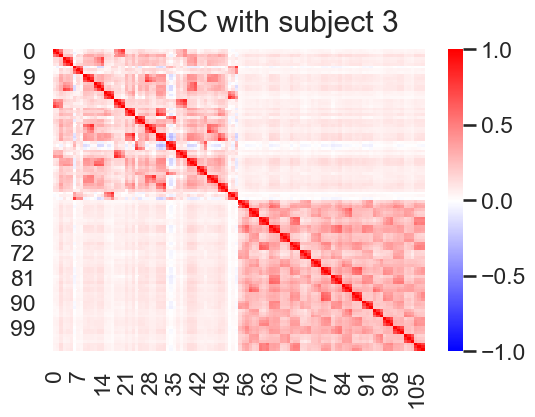

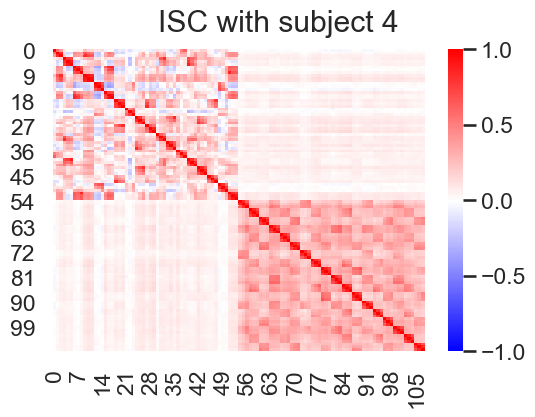

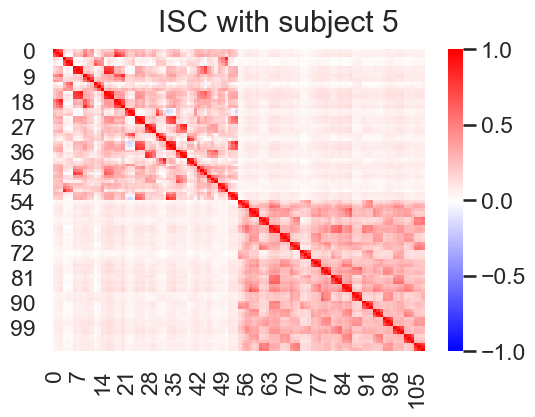

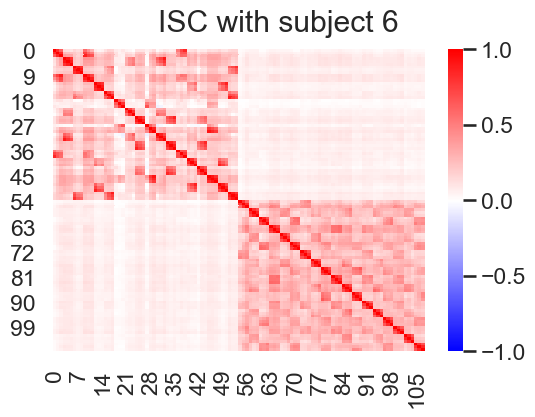

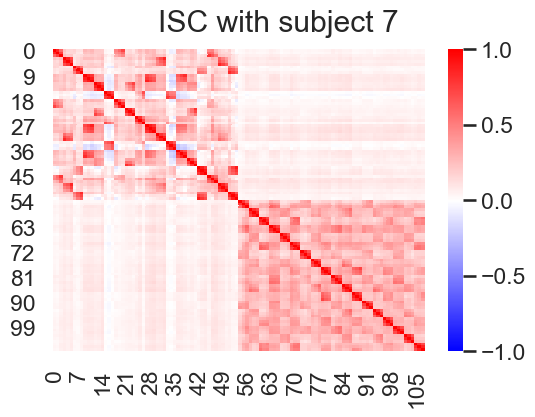

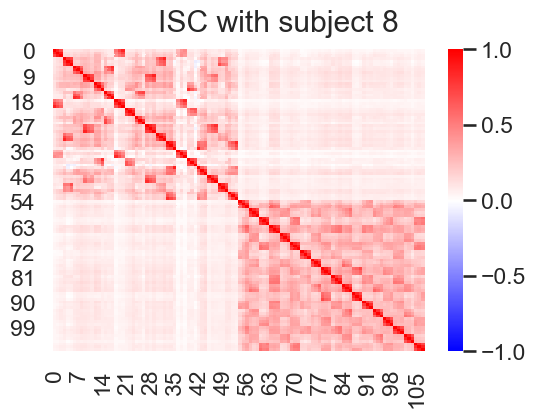

In [53]:
for i in range(num_subjects):
    
    M_sub = ISC_arr[:,:,i] # take the subject matrix 
    M_rest = np.delete(ISC_arr, i, axis=2) # remove this subjects' data from whole dataset
    # compute average of other matrices
    M_rest_mean = np.mean(M_rest, axis=2)

    # now compute correlation between mean matrix & subj matrix
    C_blockpatterns = np.corrcoef(M_sub, M_rest_mean, rowvar=True) # treat rows as variables
    
    f, ax = plt.subplots(1,1, dpi=100)
    f.suptitle(f'ISC with subject {i+1}')
    sns.heatmap(C_blockpatterns, cmap='bwr', ax=ax, vmin=-1, vmax=1);
    
## use this if want to trop upper half
#     mask = np.zeros_like(C_blockpatterns)
#     mask[np.triu_indices_from(mask)] = True
#     with sns.axes_style("white"):
#         f, ax = plt.subplots(1,1, dpi=100)
#         f.suptitle(f'ISC with subject {i+1}')
#         ax = sns.heatmap(C_blockpatterns, cmap='YlGnBu', mask=mask, vmax=.3, square=True)


## 3.2 ISC with Brainiak

- we have `ISC_arr` in the form `[levels, voxels, subjects] = (54, 179595, 8)`

### Visualise the ISC matrix for one subject back on to the brain to see *where* activity is correlated between participants.

In [87]:
isc_maps = isc(ISC_arr, pairwise=False) # The output of ISC is a voxel by 
                           # participant matrix (showing the result of each individual with the group).

In [25]:
isc_maps.shape # The output of ISC is subjects x voxels

(8, 179595)

In [26]:
isc_maps

array([[ 0.06138807,  0.23699535,  0.40447509, ..., -0.41155743,
        -0.0219993 , -0.01843884],
       [-0.1832499 ,  0.02254019,  0.213572  , ..., -0.50567629,
        -0.37708194, -0.01730231],
       [ 0.17283633, -0.13181779,  0.08256554, ..., -0.29238787,
         0.35004844, -0.10876317],
       ...,
       [-0.29358055, -0.36976425,  0.22528768, ...,  0.1749085 ,
         0.43434132,  0.04808228],
       [-0.05417781, -0.27846343,  0.05147166, ...,  0.08836725,
        -0.62188911, -0.26816987],
       [ 0.09363685,  0.14547461,  0.09365647, ...,  0.09365605,
         0.33309809, -0.07566107]])

In [39]:
data_dir = '/Users/Daphne/Desktop/beta_series/' # local directory

# load in the nifti data using nibabel module
brain_nii = nib.load(os.path.join(data_dir, 'mask_nosmooth.nii'))

In [40]:
header = brain_nii.header

In [41]:
# choose a subject
sub = 0
# get coordinates
coords_sub = np.where(mask_data[sub] == 1) 

# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)

# Map the ISC data for a subject into brain space
isc_vol[coords_sub] = isc_maps[sub,:]

# make a nii image of the isc map 
isc_nifti = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)

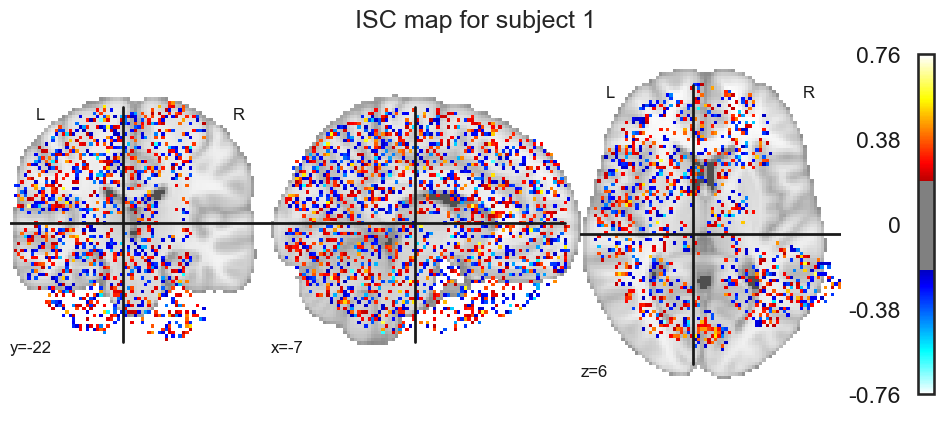

In [42]:
# Plot the data as a statmap
threshold = .2

f, ax = plt.subplots(1,1, figsize = (12, 5), dpi=100)
plotting.plot_stat_map(
    isc_nifti, 
    threshold=threshold, 
    axes=ax
)
ax.set_title(f'ISC map for subject {sub+1}');